In [1]:
import statistics

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

## Example Data

First we are going to create an example problem for us to work it. This is a simple linear equations with a slope of 3.5 and a y intercept of 10.

In order to make this example more realistic, we superimpose some Gaussian noise with the sampled from a distribution of N(0, 1) at each data point.

In [2]:
X = np.linspace(0, 10, 100)
y_noise = np.random.normal(size=100)
y = 3.5 * X + 10
y += y_noise

Text(0.5, 1.0, 'Example Data')

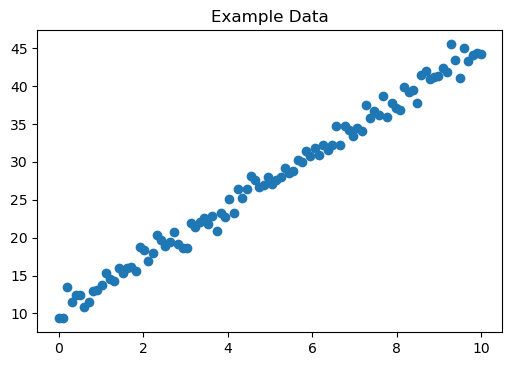

In [3]:
plt.scatter(X, y)
plt.title('Example Data')

In [4]:
f = lambda x, m, b: m * x + b

Here we fit the whole data using `curve_fit` to see what our model returns. We are fitting on the whole data just to see the best our model can perform.

In [5]:
params = curve_fit(f, X, y, [1, 1])[0]
print(params)

[ 3.47983432 10.24872549]


## Splitting Data

Here we are splitting the data into train and testing components. We are setting the training size to 70%; therefore, the testing data is 30%.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

This is a scatter plot of the training and testing data. As you can see, the testing data seems to be a realistic representation of the true underlying data. It spans the domain and the range of the function we are interested in.

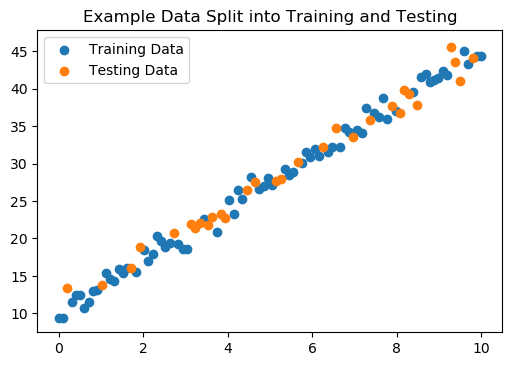

In [7]:
plt.scatter(X_train, y_train, label='Training Data')
plt.scatter(X_test, y_test, label='Testing Data')
plt.title('Example Data Split into Training and Testing')
plt.legend()

## Bootstrap/Bagging

Here we are taking 10000 bootstrap samples, each with size 50, from our training data and fitting a model to the sampled data. Then we store the fitted parameters for future use.

In [8]:
indicies = np.linspace(0, 69, 70).astype(int)

slopes = []
intercepts = []

for i in range(10000):
    sample_indicies = np.random.choice(indicies, size=50)
    X_train_sample = X_train[sample_indicies]
    y_train_sample = y_train[sample_indicies]
    slope, intercept = curve_fit(f, X_train_sample, y_train_sample, [1, 1])[0]
    slopes.append(slope)
    intercepts.append(intercept)
    
print(f'Mean of Slopes: {statistics.mean(slopes)}')
print(f'Mean of Intercepts: {statistics.mean(intercepts)}')

Mean of Slopes: 3.514685378907301
Mean of Intercepts: 10.017248177810187


Here we are looping though each pair of slopes and intercepts, using the pair to predict on the testing data, and storing the all the predictions.

In [29]:
y_hats = []
for slope, intercept in zip(slopes, intercepts):
    y_hat = f(X_test, slope, intercept)
    y_hats.append(y_hat)

In [30]:
y_hats = np.array(y_hats).T

In [31]:
def get_confidence_interval_bounds(interval, series):
    p_low = 50 - interval / 2.
    p_upp = 50 + interval / 2.
    low = np.percentile(series, p_low)
    upp = np.percentile(series, p_upp)
    return [low, upp]


def plot_parameter_distribution(
    y_hat, true_value, low, upp, title=None, xlabel=None, ylabel=None
):
    mean_estimate = statistics.mean(y_hat)
    plt.hist(y_hat, 50)
    plt.axvline(true_value, color='k', label='True Value')
    plt.axvline(low, color='y', label='Confidence Interval Bounds')
    plt.axvline(upp, color='y')
    plt.axvline(mean_estimate, color='r', label='Mean Estimate')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Here we are looking the first testing data point. We are getting all the predicted values for each parameter pair, constructing a distribution (represented by a histogram), and estimating the value at various percentiles.

We estimate the value at various percentiles by using `np.percentile` (in the `get_confidence_interval_bounds` helper function) and passing in the series of predicted values and the percentile we would like to calculate. This gives us the opporunity to inspect the precision and accuracy of the distribution by comparing it to the true value for the testing point.

Here we are using a 20% confidence interval, so we are calculating the P40 and P60 values for the predictions related to this specific data point in the testing data.

As you can see the true value lies outside of this 20% confidence interval, and we can also see that the distribution is not centered near the true value.

True Y value: 36.79140944432141
Mean Estimate: 38.41874618918232
P40 Estimate: 38.366579608184296
P60 Estimate: 38.466443477458945


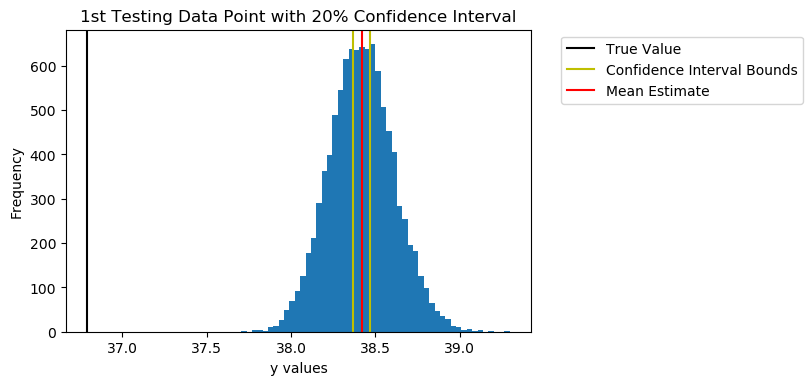

In [32]:
y_hat_0 = y_hats[0]

low, upp = get_confidence_interval_bounds(20, y_hat_0)
true_value = y_test[0]
mean_estimate = statistics.mean(y_hat_0)

plot_parameter_distribution(
    y_hat_0,
    true_value,
    low,
    upp,
    title='1st Testing Data Point with 20% Confidence Interval',
    xlabel='y values',
    ylabel='Frequency'
)

print(f'True Y value: {true_value}')
print(f'Mean Estimate: {mean_estimate}')
print(f'P40 Estimate: {low}')
print(f'P60 Estimate: {upp}')

This is the same story as above, but we are looking at the second testing point with a larger confidence interval. 

As you can see the true value lies outside of this 60% confidence interval, and we can also see that the distribution is not centered near the true value.

True Y value: 37.83175686617296
Mean Estimate: 39.83882108975092
P20 Estimate: 39.66633507256988
P80 Estimate: 40.00725695072765


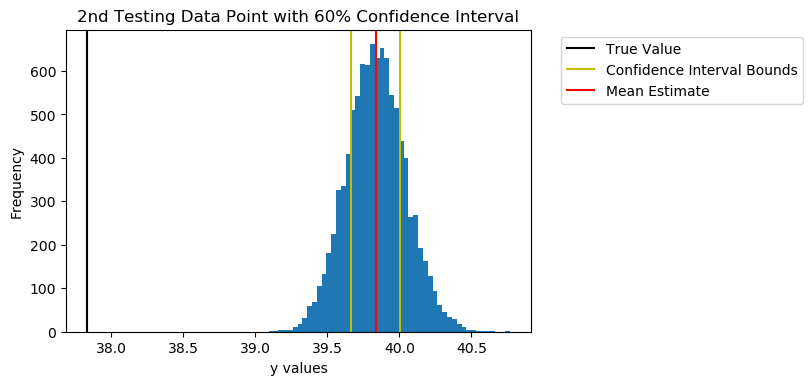

In [33]:
y_hat_1 = y_hats[1]

low, upp = get_confidence_interval_bounds(60, y_hat_1)
true_value = y_test[1]
mean_estimate = statistics.mean(y_hat_1)

plot_parameter_distribution(
    y_hat_1,
    true_value,
    low,
    upp,
    title='2nd Testing Data Point with 60% Confidence Interval',
    xlabel='y values',
    ylabel='Frequency'
)

print(f'True Y value: {true_value}')
print(f'Mean Estimate: {mean_estimate}')
print(f'P20 Estimate: {low}')
print(f'P80 Estimate: {upp}')

This is the 6th testing point. The reason we jumped this point is because it is within the 60% confidence interval.

True Y value: 16.10290363297614
Mean Estimate: 16.052566505226764
P20 Estimate: 15.884280791380444
P80 Estimate: 16.222146485243044


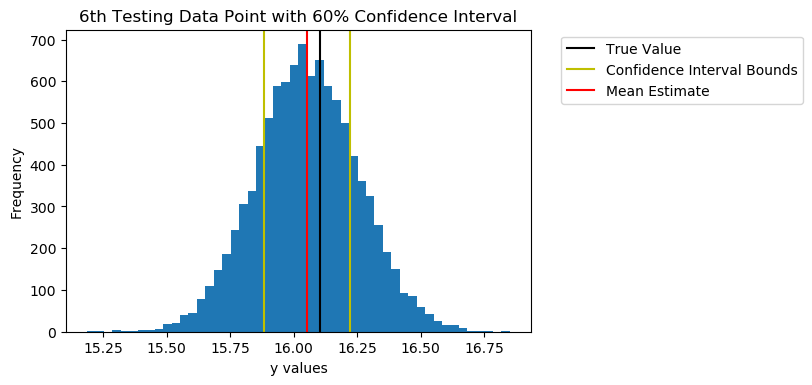

In [37]:
y_hat_6 = y_hats[5]

low, upp = get_confidence_interval_bounds(60, y_hat_6)
true_value = y_test[5]
mean_estimate = statistics.mean(y_hat_6)

plot_parameter_distribution(
    y_hat_6,
    true_value,
    low,
    upp,
    title='6th Testing Data Point with 60% Confidence Interval',
    xlabel='y values',
    ylabel='Frequency'
)


print(f'True Y value: {true_value}')
print(f'Mean Estimate: {mean_estimate}')
print(f'P20 Estimate: {low}')
print(f'P80 Estimate: {upp}')

In [38]:
for i in range(len(y_test)):
    y_hat_i = y_hats[i]
    low, upp = get_confidence_interval_bounds(60, y_hat_i)
    if low < y_test[i] <= upp:
        # print(low)
        # print(upp)
        # print(y_test[i])
        print(i)

5
6
7
15
18


In [39]:
def average_indicator_function(y_hats, y_test, confidence_interval):
    counter = 0
    length = len(y_test)
    p_low = 50 - (confidence_interval / 2.)
    p_upp = 50 + (confidence_interval / 2.)
    for i in range(len(y_test)):
        y_hat_i = []
    
        for row in y_hats:
            y_hat_i.append(row[i])
    
        low = np.percentile(y_hat_i, p_low)
        upp = np.percentile(y_hat_i, p_upp)
        if low < y_test[i] <= upp:
            counter += 1
    return counter / length

In [40]:
confidence_intervals = np.linspace(0, 100, 11)
average_indicator_values = [
    average_indicator_function(y_hats, y_test, interval)
    for interval in confidence_intervals
]
average_indicator_values[0] = 0.
average_indicator_values[-1] = 1.
print(average_indicator_values)

[0.0, 0.1, 0.2, 0.23333333333333334, 0.36666666666666664, 0.5, 0.6, 0.7, 0.8, 0.8333333333333334, 1.0]


Text(0, 0.5, 'Proportion of data in Interval, avg(ξ(p))')

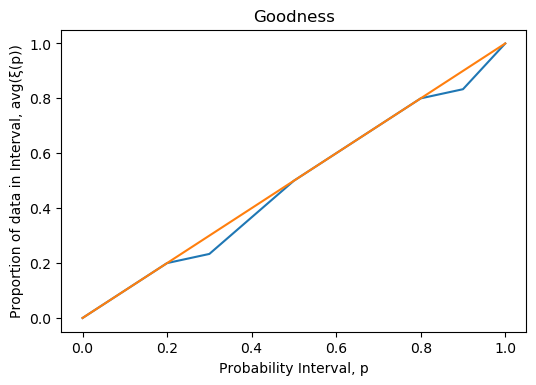

In [41]:
intervals = confidence_intervals / 100.
plt.plot(intervals, average_indicator_values)
plt.plot([0, 1], [0, 1])
plt.title('Goodness')
plt.xlabel('Probability Interval, p')
plt.ylabel('Proportion of data in Interval, avg(ξ(p))')

## Deutsch's Goodness Measure

Deutsch's "Goodness Measure" is a way to determine the usefulness of a model. The usefulness of a model can be quantified using two different metrics. Accuracy and precision.

<img src="goodness_measure_equation.png" width="500"/>

In [42]:
accuracy = []

for indicator, interval in zip(average_indicator_values, intervals):
    if indicator >= interval:
        accuracy.append(1)
    else:
        accuracy.append(0)
print(accuracy)

[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]


In [43]:
goodness = 1
summation = 0
for a, indicator, interval in zip(accuracy, average_indicator_values, intervals):
    summation += (2 * a - 2) * (indicator - interval)

goodness -= summation / len(accuracy)
print(f'Goodness: {goodness}')

Goodness: 0.9696969696969697


## References

- Maldonado-Cruz, Eduardo, and Michael J. Pyrcz. "Tuning machine learning dropout for subsurface uncertainty model accuracy." Journal of Petroleum Science and Engineering (2021): 108975.
- https://github.com/PGEHackathon/workshop/blob/main/06_model_QC/lectures/16b_Model_Checking.pdf
- https://www.youtube.com/watch?v=AVms8JoUWXc